In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## Project introduction

This project revolves around the sentiment analysis of comments left by Amazon's consumers. These texts come with a grade between 1 and 5, which we aim at predicting with an algorithm. Before beginning ordinal classification or regression, we will first use a binary regression framework. This will be justified by the initial exploration of the dataset, in particular using clustering methods. 

We have a large quantity of data, classified by themes. Our project aims at tackling two questions. First, is it possible to adequately classify comments? Second, given the specificity of each corpus, can an algorithm that has been trained on one of the corpus be effective for another one? Should that be possible, how can we understand this through an algorithmic and linguistic lens? 


## Chargement des modules nécessaires

In [0]:
! pip install transformers

In [0]:
### import modules

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoModel, AutoTokenizer
import pandas as pd
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import gzip
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from tqdm import tqdm
from nltk.stem import PorterStemmer 
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Datasets loading


In [0]:
### loading functions

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

### first load sport dataset  as df_sport ###

df_sport_ = getDF('/content/drive/My Drive/sports_review.gz')

# print the original volume of data provided by Amazon

print('initial sport dataset shape',df_sport_.shape)

# we will only train on a subset of the data for our first algorithms
# due to computational complexity

df_sport = df_sport_.loc[:15000,:]
df_sport_test = df_sport_.loc[15001:17001,:]
df_sport.index = range(len(df_sport.index))

### then load beauty dataset as df_b ###

df_b_ = getDF('/content/drive/My Drive/reviews_Beauty_5.json.gz')
print('initial beauty dataset shape',df_b_.shape)


df_b = df_b_.loc[:100000,:]
df_b_test = df_b_.loc[100001:105001,:]
df_b.index = range(len(df_b.index))

df_auto = getDF('/content/drive/My Drive/reviews_Automotive_5.json.gz')
df_auto.index = range(len(df_auto.index))

initial sport dataset shape (296337, 9)
initial beauty dataset shape (198502, 9)


## Cleaning and tagging functions

The following functions remove stopwords, punctuation, special characters, numbers that cannot help our analysis, and then tokenize the word sequences using the TreeBankworldTokenizer tool from nltk.

In a second stage, we use Part-Of-Speech tagging to improve our performance. In this matter, two possibilities arise: we can either add the tag provided by the POS algorithm to each token, or add to each token list (whole comments) the ordered list of tags provided by the POS tagging. In further developments, the latter strategy will allow an interesting improvement of our performances.

In [0]:
### POS tagging : 2 strategies : accoler son tag à chaque token, ou accoler la séquence des tags à la fin de chaque liste de tokens

def pos_tagging(tokens,text_tagged):

  # returns 'word_tag' instead of 'word' for every word in token

  new_text = []
  for word in text_tagged:
    new_text.append(word[0] + "_" + word[1])

  doc = ' '.join(new_text)
  return doc

def second_pos_tagging(tokens,text_tagged):

  # returns all tags at the end of the tokens list

  for word in text_tagged:
    tokens.append(str(word[1]))

  #doc = ' '.join(new_text)
  return list(tokens)

In [0]:
### remove numbers : not relevant to our 
# as they do not specify feeling nor corpus theme

import re

def remove_numbers(sent): 
  sent = re.sub(r'\d+', '', sent)

  return sent

df_sport.reviewText = df_sport.reviewText.apply(lambda x : remove_numbers(x))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [0]:
### cleaning functions

# remove punctuation and lower case reviews


df_sport.reviewText = df_sport.reviewText.str.lower()
df_sport.reviewText = df_sport.reviewText.str.translate(str.maketrans('', '', string.punctuation))

#df_polarized.reviewText = df_polarized.reviewText.str.lower()
#df_polarized.reviewText = df_polarized.reviewText.str.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(tokens):
    
    tokens = [w for w in tokens if not w in stop_words]
    return list(tokens)

ps = PorterStemmer()

def clean_token(tokens):
    
    ### cleans and stems
    
    tokens = map(lambda x: x.replace('&', ''), tokens)
    tokens = map(lambda x: x.replace('#', ''), tokens)
    
    #tokens = map(lambda x : ps.stem(x),tokens) # stemming does not seem to improve performance
    return list(tokens)


### tokenize text array

def tokenize(corpus,tweets = False,pos_1=False,pos_2=False):

    ### l'option pos indique si l'on recourt à une stratégie de feature engineering employant du part of speech tagging
    
    ### tokenizer : string, choice of tokenizer
    if tweets : 
        tokenizer = TweetTokenizer()
    else :
        tokenizer = TreebankWordTokenizer()
    tokenized_sentences = []
    for sample in tqdm(corpus):

        tokens = tokenizer.tokenize(sample)
        text_tagged = nltk.pos_tag(tokens)
        tokens = remove_stopwords(tokens)
        tokens = clean_token(tokens)
        if pos_2 :
          tokens = second_pos_tagging(tokens,text_tagged)
        if pos_1 :
          tokens = pos_tagging(tokens,text_tagged)
        tokenized_sentences.append(tokens)
      
    return tokenized_sentences

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [0]:
### clean and tokenize dataset for clustering purposes, no part of speech tagging for the moment

X_ = tokenize(df_sport.reviewText.array)
X = [' '.join(x) for x in X_] 

100%|██████████| 15001/15001 [01:00<00:00, 249.92it/s]


## Vectorizing and embedding functions

As a first step, two strategies of text vectorial representation are used : bag of words (with the CountVectorizer tool from sickit-learn) and Word2Vec embeddings.

In [0]:
### create matrix representation : bag of words approach

def vectorize(X):
    
    ### X : cleaned and tokenized text
    
    vectorizer = TfidfVectorizer()
    X_vectorizer = vectorizer.fit_transform(X)

    W = X_vectorizer.toarray()
    
    return W

W = vectorize(X)

#W.shape

In [0]:
### create word embeddings with word2vec


from multiprocessing import cpu_count
cpu = cpu_count()

p = Word2Vec(X_, size=100, window=5, min_count=3, workers=cpu) 

p_wv = p.wv

In [0]:
def tokens2vectors(tokenCorpus):
  ''' transforms our X into a list of list of vec (2D array) '''
  new_sample = list()
  for sample in tokenCorpus:
    tweetVecs = list()
    for token in sample.split(' '):
      try: tweetVecs.append(p_wv.get_vector(token)  )
      except: tweetVecs.append( np.zeros(100) ) 
    new_sample.append(np.mean(tweetVecs, axis=0))
  return np.array(new_sample)

## Exploration des données à l'aide de méthodes de clustering

We aim in this step at checking whether, in a non supervised way, it is possible to identify homogeneous groups of comments. Such an approach is quite useful as it provides an indication on the possibility to operate in a multiclass framework, and if so, the number of classes to consider. For instance, it seems intuitive that distinguishing a comment associated to a 3/5 grade and another one associated with a 2/5 or a 4/5 will be quite uneasy, given the proximity of the grading. 

In this step, we will see that the best we can do is identify two main groups, which will prompt us to adopt a binary classification framework before training our algorithms in a multiclass context. 



In [0]:
### embeddings clustering : we will wuse word2vec embeddings for reasons of computational costs

# first, try 2-clustering

k = 2
df_sport.index = range(len(df_sport.index))
X_clust = tokens2vectors(df_sport.loc[:,'reviewText'])
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=1000, verbose=0).fit(X_clust)
clusters = kmeans.labels_

In [0]:
# compute compositions of the two clusters

for i in range(k):  
  print('------------------')
  print('Composition of cluster number',i+1)
  print(df_sport.overall[clusters == i].value_counts(normalize = True))
  print('------------------')

------------------
Composition of cluster number 1
5.0    0.726556
4.0    0.199380
3.0    0.048155
2.0    0.015489
1.0    0.010420
Name: overall, dtype: float64
------------------
------------------
Composition of cluster number 2
5.0    0.633275
4.0    0.210306
3.0    0.084716
2.0    0.038865
1.0    0.032838
Name: overall, dtype: float64
------------------


We generally find a cluster with articles with grades from 1 to 3. 
When adding more than two clusters, the results are not satisfying. For three clusters (which could correspond to a space partition of vectors between positive, neutral, and negative comments) or five clusters on the Word2Vec vectors : results are less efficient. 

In [0]:
# try 3-clustering

k = 3
df_sport.index = range(len(df_sport.index))
X_clust = tokens2vectors(df_sport.loc[:,'reviewText'])
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=1000, verbose=0).fit(X_clust)
clusters = kmeans.labels_
for i in range(k):  
  print('------------------')
  print('Composition of cluster number',i+1)
  print(df_sport.overall[clusters == i].value_counts(normalize = True))
  print('------------------')

------------------
Composition of cluster number 1
5.0    0.757200
4.0    0.174568
3.0    0.045193
2.0    0.014178
1.0    0.008861
Name: overall, dtype: float64
------------------
------------------
Composition of cluster number 2
5.0    0.619271
4.0    0.248156
3.0    0.084954
2.0    0.030181
1.0    0.017438
Name: overall, dtype: float64
------------------
------------------
Composition of cluster number 3
5.0    0.647080
4.0    0.194898
3.0    0.079676
2.0    0.040261
1.0    0.038085
Name: overall, dtype: float64
------------------


In [0]:
# try 5-clustering

k = 5
df_sport.index = range(len(df_sport.index))
X_clust = tokens2vectors(df_sport.loc[:,'reviewText'])
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=1000, verbose=0).fit(X_clust)
clusters = kmeans.labels_
for i in range(k):
  print('------------------')
  print('Composition of cluster number',i+1)  
  print(df_sport.overall[clusters == i].value_counts(normalize = True))
  print('------------------')

------------------
Composition of cluster number 1
5.0    0.630402
4.0    0.242921
3.0    0.082265
2.0    0.028316
1.0    0.016095
Name: overall, dtype: float64
------------------
------------------
Composition of cluster number 2
5.0    0.777166
4.0    0.189821
3.0    0.022008
2.0    0.005502
1.0    0.005502
Name: overall, dtype: float64
------------------
------------------
Composition of cluster number 3
5.0    0.689446
4.0    0.193288
3.0    0.065507
2.0    0.027093
1.0    0.024666
Name: overall, dtype: float64
------------------
------------------
Composition of cluster number 4
5.0    0.732729
4.0    0.148532
3.0    0.050086
1.0    0.039724
2.0    0.028929
Name: overall, dtype: float64
------------------
------------------
Composition of cluster number 5
5.0    0.611582
4.0    0.218760
3.0    0.093148
2.0    0.043556
1.0    0.032953
Name: overall, dtype: float64
------------------


## First attemps of classification

Accordingly to what has been explained before, we operate here in a binary framework for our first attempts. The label to predict is a binary variable indicating whether the grade is above 3. 

In this section, we compare two strategies of vectorial representation of text, bag of words and Word2Vec, as well as two strategies of feature engineering, with or without POS tagging. Hence, four methods. Using POS tagging improves performances or the algorithm trained with embedding products by Word2Vec. The idea is to provide the algorithm with a clearer intuition of the analyzed sentences' strucure. 



# Choosing a binary label

Beforehand, in order to know how to create our binary label, we must know which threshold to use. To do so, we calculate a positivity score on the subsets of our initial dataset reduced to a single grade. We will try to identify a breaking point, an "elbow" in the curve of positivity scores obtained for the comments. 

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
for k in range(1,6):
  subset = (df_sport.overall == k)
  df_5 = df_sport[subset]
  sentences = df_5.reviewText
  score = []
  for sentence in sentences:
    ss = sid.polarity_scores(sentence)
    score.append(ss['compound'])
  print('note des critiques :',k,', score de positivité calculé à partir du lexique :',np.mean(score))

note des critiques : 1 , score de positivité calculé à partir du lexique : -0.012871428571428565
note des critiques : 2 , score de positivité calculé à partir du lexique : 0.14830500000000002
note des critiques : 3 , score de positivité calculé à partir du lexique : 0.3438272567922875
note des critiques : 4 , score de positivité calculé à partir du lexique : 0.5681791399229781
note des critiques : 5 , score de positivité calculé à partir du lexique : 0.6266543078018513


The proximity of the scores for comments associated with 4 and 5 grades suggests a to set the threshold at 4 for a binary classification.

# Classification without POS tagging

In [0]:
X_ = tokenize(df_sport.reviewText.array)
X = [' '.join(x) for x in X_] 

100%|██████████| 15001/15001 [01:00<00:00, 249.73it/s]


In [0]:
y = np.array(df_sport.overall.apply(lambda x : (x >= 4)))

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [0]:
X_train_vec = tokens2vectors(X_train)
X_test_vec = tokens2vectors(X_test)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
clf = RandomForestClassifier(max_depth=6, random_state=0).fit(X_train_vec, y_train)
a = clf.predict_proba(X_test_vec)[:,1]
print('AUC score with Word2Vec and no POS',roc_auc_score(y_test,a))

AUC score with Word2Vec and no POS 0.7434393404836241


In [0]:
clf = RandomForestClassifier(max_depth=6, random_state=0).fit(X_train_vect, y_train)
a = clf.predict_proba(X_test_vect)[:,1]
print('AUC score with Bag of Words and no POS',roc_auc_score(y_test,a))

AUC score with Bag of Words and no POS 0.7872734059657922


# Classification with POS tagging (first strategy)

In [0]:
X_ = tokenize(df_sport.reviewText.array,pos_1=True)
X = [' '.join(x) for x in X_] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

100%|██████████| 15001/15001 [01:00<00:00, 246.79it/s]


In [0]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [0]:
X_train_vec = tokens2vectors(X_train)
X_test_vec = tokens2vectors(X_test)

In [0]:
clf = RandomForestClassifier(max_depth=6, random_state=0).fit(X_train_vec, y_train)
a = clf.predict_proba(X_test_vec)[:,1]
print('AUC score with Word2Vec and POS',roc_auc_score(y_test,a))

AUC score with Word2Vec and POS 0.7434393404836241


In [0]:
clf = RandomForestClassifier(max_depth=6, random_state=0).fit(X_train_vect, y_train)
a = clf.predict_proba(X_test_vect)[:,1]
print('AUC score with Bag of Words and POS',roc_auc_score(y_test,a))

AUC score with Bag of Words and POS 0.7872734059657922


# Studying the distance between text corpus

Before using a BERT model type which will allow us to tackle the question in introduction about the generalization of the prediction capacity from a given corpus, as well as possibly improve performances, we focus on calculating a distance between our two reference corpus (one about sports items, the other about beauty items). 
To do so, we compute the earth mover distance or wod mover distance between several sentences excerpted from both corpus embeddings provided by Word2Vec. Before that, we must train the model on both corpuses and not just one, as was done before. In this latter case, our embeddings would not allow to understand the differences between two sentences from different corpus.  

The interest of this metric is to compare sentences with no common words between themselves, thus operating at the semantic level. This way, we get an idea of the possibility to generalize the results from learning on one particular corpus to other corpuses, as well as of the interest of realizing this experience.

In [0]:
### concatenate sport and beauty small test datasets

import pandas as pd
df_sport_test.index = range(len(df_sport_test.index))
df_b_test.index = range(len(df_sport_test.index),len(df_b_test.index) + len(df_sport_test.index))
df_conc = pd.concat([df_sport_test,df_b_test])
df_conc.shape

(7002, 9)

In [0]:
### first train gensim on both sport and beauty data, with POS 2 

X_ = tokenize(df_conc.reviewText.array,pos_2=True)
X = [' '.join(x) for x in X_] 

p = Word2Vec(X_, size=100, window=5, min_count=3, workers=cpu) 

100%|██████████| 7002/7002 [00:30<00:00, 227.28it/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  from ipykernel import kernelapp as app


0.7724028395928604


(array([ 3726., 12451.,  5618.,  1805.,   465.,   257.,   432.,   139.,
           88.,    19.]),
 array([0.08798912, 0.43615464, 0.78432015, 1.13248567, 1.48065119,
        1.82881671, 2.17698222, 2.52514774, 2.87331326, 3.22147878,
        3.56964429]),
 <a list of 10 Patch objects>)

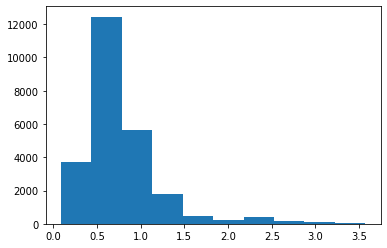

In [0]:
### then compute mean Wasserstein distance between sentences on sentences from samples from sport and beauty datasets

test_sport = df_sport_test.sample(frac=0.05)
test_sport.index = range(len(test_sport.index))
test_b = df_b_test.sample(frac=0.05)
test_b.index = range(len(test_b.index))
scores = []

for i in range(len(test_sport.index)):
  for j in range(len(test_b.index)):

    p_wmd = p.wmdistance
    sentence_a = test_sport.reviewText[i]
    sentence_b = test_b.reviewText[j]
    distance = p_wmd(sentence_a, sentence_b)
    scores.append(distance)

print(np.mean(scores))
plt.hist(scores)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  


0.09727619118536458


(array([1839., 3825., 2370., 1194.,  559.,  224.,  114.,   50.,   21.,
           5.]),
 array([0.0077735 , 0.04939557, 0.09101765, 0.13263973, 0.1742618 ,
        0.21588388, 0.25750596, 0.29912803, 0.34075011, 0.38237219,
        0.42399426]),
 <a list of 10 Patch objects>)

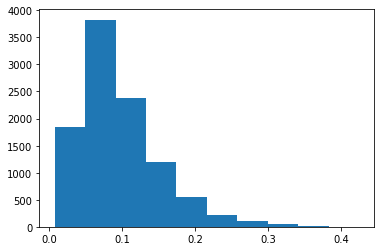

In [0]:
### compare with distances between only sport sentences

sport_1 = df_sport.loc[0:100,:]
sport_1.index = range(len(sport_1.index))
sport_2 = df_sport.loc[101:201,:]
sport_2.index = range(len(sport_2.index))
scores = []
for i in range(len(sport_1.index)):
  for j in range(len(sport_2.index)):

    sentence_a = sport_1.reviewText[i]
    sentence_b = sport_2.reviewText[j]
    
    distance = p_wmd(sentence_a, sentence_b)
    
    scores.append(distance)

print(np.mean(scores))
plt.hist(scores)

In the second case, the average score is much lower, and the score distribution has a mode between 0 and 0.1, when for the first case it is 0.5. Does that work so well with an other distance? Let's use the cosine distance from sklearn. 

In [0]:
### Let's have a comparison with cosine distance

# distance between sport texts

from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from scipy.spatial import distance
W = vectorize(X)
a = int(len(df_sport_test.index)/2)
sport_1 = W[:a]
print(sport_1.shape)
sport_2 = W[a+1:2*a]
print(sport_2.shape)
print(cosine_distances(sport_1,sport_2).shape)
print(np.mean(np.triu(cosine_distances(sport_1,sport_2))))

(1000, 16614)
(999, 16614)
(1000, 999)
0.3866675803741816


In [0]:
beaut = W[len(df_sport_test.index)+1:]
print(np.mean(np.triu(cosine_distances(beaut,sport_2))))

0.0737489135990525


The cosine distance confirms the results from the word mover distance, which allows us to have a more robust meaning for the distance between different texts.

# Transfer Learning using BERT

In this part, we aim at improving our performances. Despite the improvement brought by the feature engineering method, our results remain not satisfying enough to go multiclass. Moreover, the bag of words method is heavy in terms of calculus complexity and prevents us from to take advantage of the large volume of data we have. 
The BERT model has even more interest for us, as it relies on "sub word units" allowing it to predict from words it has not yet met during the training phase. We will then be able to explore the problematic of the generalization of our algorithm from a learning focused on a particular corpus. 

The training is quite long on the 300000 comments for the df_sport_ database (1h30 by epoch). We wil train on ds_sport if we want to run the notebook faster.

In [0]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [0]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [0]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
# we will use a specific tokenizer for BERT
# as it operates on sub word units

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
def tokenize_bert(corpus,maxlen = 64):
    
    
    input_ids = []
    attention_masks = []

    for sample in tqdm(corpus):

        encoded_dict = tokenizer.encode_plus(
                        sample,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = maxlen,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

      
    return input_ids, attention_masks

input_ids, attention_masks = tokenize_bert(df_sport_.reviewText.array)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(labels)


100%|██████████| 296337/296337 [10:27<00:00, 472.56it/s]


In [0]:
def encode_labels(x):
  if x >= 4 :
    return 1
  else :
    return 0

labels = np.array(df_sport_['overall'].apply(lambda x : encode_labels(x)))

In [0]:
labels = torch.tensor(labels)

In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

266,703 training samples
29,634 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [0]:
### The epsilon parameter eps = 1e-8 is “a very small number to prevent any division by zero in the implementation” ###

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 

optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime
import random
import numpy as np

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of  8,335.    Elapsed: 0:00:26.
  Batch    80  of  8,335.    Elapsed: 0:00:52.
  Batch   120  of  8,335.    Elapsed: 0:01:18.
  Batch   160  of  8,335.    Elapsed: 0:01:44.
  Batch   200  of  8,335.    Elapsed: 0:02:10.
  Batch   240  of  8,335.    Elapsed: 0:02:36.
  Batch   280  of  8,335.    Elapsed: 0:03:03.
  Batch   320  of  8,335.    Elapsed: 0:03:29.
  Batch   360  of  8,335.    Elapsed: 0:03:55.
  Batch   400  of  8,335.    Elapsed: 0:04:21.
  Batch   440  of  8,335.    Elapsed: 0:04:47.
  Batch   480  of  8,335.    Elapsed: 0:05:13.
  Batch   520  of  8,335.    Elapsed: 0:05:39.
  Batch   560  of  8,335.    Elapsed: 0:06:05.
  Batch   600  of  8,335.    Elapsed: 0:06:32.
  Batch   640  of  8,335.    Elapsed: 0:06:58.
  Batch   680  of  8,335.    Elapsed: 0:07:24.
  Batch   720  of  8,335.    Elapsed: 0:07:50.
  Batch   760  of  8,335.    Elapsed: 0:08:16.
  Batch   800  of  8,335.    Elapsed: 0:08:42.
  Batch   840  of  8,335.    Elapsed: 0:09:08.
  Batch   880

In [0]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

### signs of overfitting when we start to increase the number of epochs ###

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.24,0.21,0.92,1:30:39,0:03:12
2,0.17,0.21,0.92,1:30:40,0:03:12


In [0]:
### evaluate test data performance on 2000 observations from sport data


labels_test = np.array(df_sport_test['overall'].apply(lambda x : encode_labels(x)))

In [0]:
input_ids, attention_masks = tokenize_bert(df_sport_test.reviewText.array)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_test)

100%|██████████| 2001/2001 [00:04<00:00, 485.29it/s]


In [0]:
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels by batch
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,001 test sentences...
    DONE.


In [0]:
# Combine the results across all batches. 
from sklearn.metrics import roc_auc_score
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
auc = roc_auc_score(flat_true_labels, flat_predictions)

print(auc)

0.8992566601966597


In [0]:
### Let's have a look at some of the samples where the model failed ###


df_sport_test.index = range(len(df_sport_test.index))
failed_subset = df_sport_test.reviewText[flat_predictions != flat_true_labels]
idx = list(failed_subset.index)
for i in idx :
   print(i,flat_predictions[i],flat_true_labels[i],failed_subset[i]) 

0 1 0 At one time, you just needed to see the Everlast brand name to be assured that you were getting a top-quality product: one that would withstand anything you could throw at it.Now that they've outsourced their manufacturing to China, Everlast quality is not the virtual guarantee that it once was.I purchased (and use) these wraps.  However, one of them was manufactured improperly.  The velcro closure is sewn to a different side of the wrap than it is on all the others.  Because of this, I always ended up putting it on backwards.  I finally marked it so I would know to put it on differently than the others.For around $10, you should expect to get something that has passed a quality-control check.  After all, wraps are just some strips of cloth and velcro; they probably cost about $0.25 to manufacture.These wraps are short, just over 100 inches, but fine for hitting the bag.  They are not elasticized, but that is fine for my purposes, as it's what I prefer.  If you want to do serious

Several cases in which the algorithm cannot make an accurate prediction can be identified: 
- First, we have the cases that we identified at the beginning, with "intermediary" grades, in particular 3/5, which are hard to classify. 

Some other issues at the linguistic level arise. 
- Complex grammatical structures lead the algorithm astray: using nuances, contradiction principles, lead to distubed predictions. In the following sentence, for which the algorithm could not provide an accurate prediction, the opposition of the brand's usual "top quality" and the poorness of the item reviewed may have been a difficulty for the predictor:  'At one time, you just needed to see the Everlast brand name to be assured that you were getting a top-quality product: one that would withstand anything you could throw at it.Now that they've outsourced their manufacturing to China, Everlast quality is not the virtual guarantee that it once was.I purchased (and use) these wraps.  However, one of them was manufactured improperly.  The velcro closure is sewn to a different side of the wrap than it is on all the others.  Because of this, I always ended up putting it on backwards.  I finally marked it so I would know to put it on differently than the others.For around \$10, you should expect to get something that has passed a quality-control check.'

# Can the algorithm be generalized to a different theme?

In [0]:
labels_test = np.array(df_b_test['overall'].apply(lambda x : encode_labels(x)))

In [0]:
input_ids, attention_masks = tokenize_bert(df_b_test.reviewText.array)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_test)

100%|██████████| 5001/5001 [00:10<00:00, 465.74it/s]


In [0]:
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels by batch
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 5,001 test sentences...
    DONE.


In [0]:
# Combine the results across all batches. 
from sklearn.metrics import roc_auc_score
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
auc = roc_auc_score(flat_true_labels, flat_predictions)

print(auc)

0.8316309557519357


The model achieves very good results on a corpus with a different theme (here, beauty items) from the one which it was trained on.

To understand this phenomenon, we focus on the sentences for which the prediction was inaccurate.

In [0]:
### Look at the sentences where the model failed ###

df_b_test.index = range(len(df_b_test.index))
failed_subset = df_b_test.reviewText[flat_predictions != flat_true_labels]
idx = list(failed_subset.index)
for i in idx :
   print(i,flat_predictions[i],flat_true_labels[i],failed_subset[i]) 

16 0 1 As soon as I stop using this shampoo, my scalp starts feeling itchy....That's why I always end up going back.
20 0 1 The product is good for special hair care, but I would not suggest to use the product daily since its strong effect.
21 1 0 First, the good stuff:This shampoo is generally effective at controlling (or at least reducing the severity of) severe seborrheic dermatitis (seb derm).  With regular use, it reduces itching, scaling, redness and greasiness.Now for the bad stuff:If you wear silver jewelry -- rings, earrings, piercings, etc. -- do yourself a huge favor and remove them before you get into the shower.  I discovered that this shampoo turns my sterling silver jewelry BLACK.  I'm not kidding.  I've never had ANY other shampoo or skin care product do this.  My silver ring, after coming into contact with this shampoo, looked like it had been thrown into a fire.  I had to spend an hour polishing it to get it shiny again.  I contacted the manufacturer about this bizarr

Analyzing these results confirm the following hypothesis: reviews relying on a very specific vocabulary with many references to a specific semantic field are harder to predict. For instance: "I ordered this product in peach bisque shade, for reference I am not white but have very light skin with a little pink in my cheeks.  I was very sad when I put this tinted moisturizer on my face because it looked a little dark and orange for my skin tone."

We test selected sentences to test this hypothesis. 

# Qualitative test for BERT

In this section, we test the hypothesis according to which the model cannot be generalized to reviews with specific and detailed lexicon, a vocabulary exclusive to the theme of the corpus, which is distinct from which the algorithm was trained on. We use the following example: 'Very oily and creamy. Ordered this to try to highlight and contour and it just looked awful'. That the algorithm is generalisable entails two possibilities for the data : 
- either the reviews rely on a quite poor vocabulary,
- or they rely on a specific vocabulary only rarely throughout the comments, and mostly used generic expression such as "great article". What happens without this type of markers for the algorithm?


In [0]:
labels_test = np.array([0])

In [0]:
input_ids, attention_masks = tokenize_bert(np.array(['Very oily and creamy. Ordered this to try to highlight and contour and it just looked awful']))

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_test)

100%|██████████| 1/1 [00:00<00:00, 373.39it/s]


In [0]:
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels by batch
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1 test sentences...
    DONE.


In [0]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_predictions

array([1])

# Multi-class setting

In [0]:
def tokenize_bert(corpus,maxlen = 64):
    
    
    input_ids = []
    attention_masks = []

    for sample in tqdm(corpus):

        encoded_dict = tokenizer.encode_plus(
                        sample,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = maxlen,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

      
    return input_ids, attention_masks
input_ids, attention_masks = tokenize_bert(df_sport.reviewText.array)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(labels)

100%|██████████| 15001/15001 [00:26<00:00, 563.53it/s]


In [0]:
def encode_three_class(x):
  if x >= 4 :
    return 2
  elif x == 3 :
    return 1
  elif x <= 2 :
    return 0
labels = np.array(df_sport['overall'].apply(lambda x : encode_three_class(x)))

In [0]:
labels = torch.tensor(labels)

In [0]:
from torch.utils.data import TensorDataset, random_split
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [0]:
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # learning_rate
                  eps = 1e-8 
                )

In [0]:
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of    422.    Elapsed: 0:00:26.
  Batch    80  of    422.    Elapsed: 0:00:52.
  Batch   120  of    422.    Elapsed: 0:01:17.
  Batch   160  of    422.    Elapsed: 0:01:43.
  Batch   200  of    422.    Elapsed: 0:02:09.
  Batch   240  of    422.    Elapsed: 0:02:35.
  Batch   280  of    422.    Elapsed: 0:03:01.
  Batch   320  of    422.    Elapsed: 0:03:27.
  Batch   360  of    422.    Elapsed: 0:03:52.
  Batch   400  of    422.    Elapsed: 0:04:18.

  Average training loss: 0.39
  Training epcoh took: 0:04:32

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.37
  Validation took: 0:00:10

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    422.    Elapsed: 0:00:26.
  Batch    80  of    422.    Elapsed: 0:00:52.
  Batch   120  of    422.    Elapsed: 0:01:17.
  Batch   160  of    422.    Elapsed: 0:01:43.
  Batch   200  of    422.    Elapsed: 0:02:09.
  Batch   240  of    422.    Elapsed: 0:02:35.
  Batch   280  of    422.    Elapsed: 0:03:01.
  Bat

In [0]:
### evaluate test data performance on 2000 observations from sport data


labels_test = np.array(df_sport_test['overall'].apply(lambda x : encode_three_class(x)))

In [0]:
input_ids, attention_masks = tokenize_bert(df_sport_test.reviewText.array)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_test)

100%|██████████| 2001/2001 [00:04<00:00, 498.57it/s]


In [0]:
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels by batch
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,001 test sentences...
    DONE.


In [0]:
# Combine the results across all batches, and get a look at the confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
confusion_matrix(flat_true_labels, flat_predictions)

array([[  48,   36,   44],
       [   7,   38,   98],
       [  14,   41, 1675]])

In a multiclass context, we obtain fairly good results, but only for the most represented class. With a three-class prediction, one of the classes being devoted to the 3/5 grades only, we reach a 0.87 accuracy score, and the dominant class is correctly predicted, but for the other classes predictions are less efficient. This confirms the difficulty of multi class sentiment analysis as underlined by our clutering initial approach.